In [8]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from keras.models import load_model
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler

In [9]:
look_back = 40
forward_days = 10
num_periods = 20

In [10]:
df = pd.read_csv('./data.csv')
df.set_index('time_original', inplace=True)
df = df.sort_index()
df = df[['close']]

In [11]:
len(df)

10005

In [12]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[10968.3 ],
       [11014.67],
       [10963.79],
       [10562.17],
       [10585.41]])

In [13]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.90735567],
       [0.91276016],
       [0.90683003],
       [0.86002068],
       [0.86272933]])

In [14]:
division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [15]:
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [16]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(7804, 40, 1)
(1952, 40, 1)
(20, 40, 1)
(7804, 10)
(1952, 10)
(20, 10)


In [18]:
model = load_model('./LSTM_hourly.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 40, 50)            10400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
Total params: 20,430
Trainable params: 20,430
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dropout(0.25))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

#history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

In [21]:
#Saving the model
file_name = './LSTM_hourly.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `./LSTM_hourly.h5` to disk


In [22]:
Xt = model.predict(X_test)

In [43]:
#Mean absolute error
mae_values=[]
mae_days =[]

for i,v in enumerate(Xt):
    prediction = np.ravel(scl.inverse_transform(Xt[i].reshape(-1,1)))
    actual = np.ravel(scl.inverse_transform(y_test[i].reshape(-1,1)))
    print("Predicted:"+ str(np.where(prediction==min(prediction))[0][0])+"----Actual:"+ str(np.where(actual==min(actual))[0][0]))
    mae = (abs(prediction - actual)).mean()
    mae_days.append(abs(np.where(prediction==min(prediction))[0][0]-np.where(actual==min(actual))[0][0]))
    mae_values.append(mae)

print("MAE: "+ str(np.mean(mae_values)))
print("MAE_days: "+ str(np.mean(mae_days)))


Predicted:0----Actual:6
Predicted:0----Actual:0
Predicted:0----Actual:6
Predicted:0----Actual:1
Predicted:2----Actual:9
Predicted:0----Actual:0
Predicted:0----Actual:0
Predicted:0----Actual:6
Predicted:0----Actual:0
Predicted:0----Actual:1
Predicted:0----Actual:0
Predicted:0----Actual:6
Predicted:0----Actual:3
Predicted:0----Actual:1
Predicted:0----Actual:0
Predicted:1----Actual:8
Predicted:0----Actual:0
Predicted:1----Actual:8
Predicted:0----Actual:9
Predicted:0----Actual:7
MAE: 52.79510131835938
MAE_days: 3.35


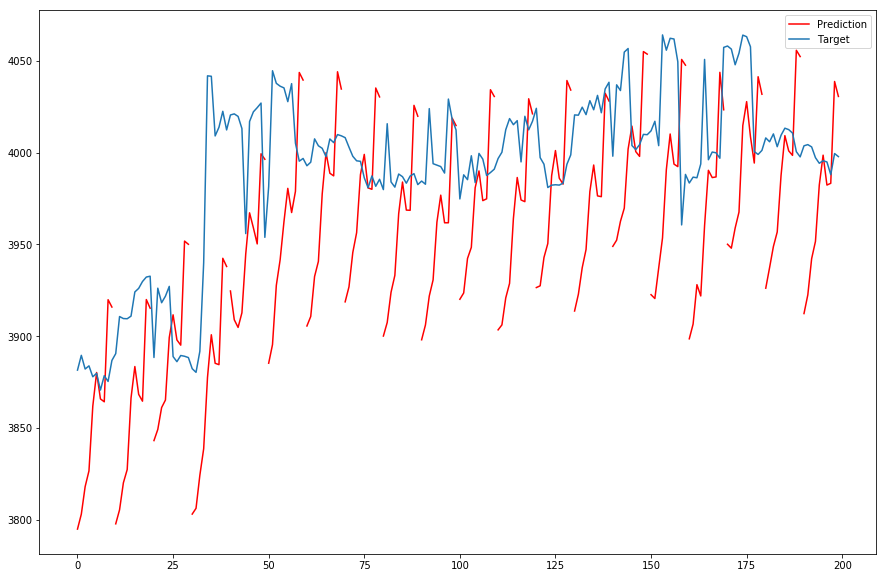

In [55]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()